# 고양이 수염 붙이기

flaticon에서 스티커를 다운로드한다. 세 부분으로 나누어 붙인다.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
print("Job Done")

Job Done


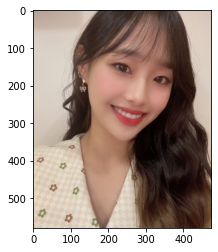

In [2]:
import os
my_image_path = '/content/drive/MyDrive/AIffel2021/Ex03-FaceRecognition/images/Test1.png'
img_bgr = cv2.imread(my_image_path)  # BGR 기반
img_bgr = cv2.resize(img_bgr, (474, 579))
img_show = img_bgr.copy()
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [3]:
import dlib
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 2)

In [4]:
model_path = '/content/drive/MyDrive/AIffel2021/Ex03-FaceRecognition/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [5]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


In [6]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 코 위에 고양이 코를 얹으려고 한다
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] 
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(283, 238)
(x,y) : (283,238)
(w,h) : (232,232)


스티커를 불러온다

In [7]:
sticker_path = '/content/drive/MyDrive/AIffel2021/Ex03-FaceRecognition/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
print (img_sticker.shape)

(512, 512, 3)


정면의 코 이식부터 시작한다. 512 x 512 px인 원래의 스티커 이미지에서 원하는 영역을 잘라내어 사용한다.

## 시행착오의 기록들

안정적인 결과를 얻기까지 많은 개선이 진행되었다.

### 자르기, 회전 x

251 294
(86, 86, 3)


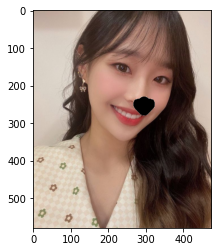

In [8]:
img_show = img_bgr.copy()

#crop nose
original_width = 512
nose_left = 188
nose_width = 136
nose_top = 176
nose_height = 128

landmarks = list_landmarks[0]

nose_x = landmarks[31][0]
nose_y = landmarks[29][1]
nose_length = 2 * (landmarks[35][0]-nose_x)
print(nose_x, landmarks[35][0])

sticker_nose = img_sticker[nose_top:nose_top+nose_height, nose_left:nose_left+nose_width]
sticker_nose = cv2.resize(sticker_nose, (nose_length, nose_length))

sticker_area = img_show[nose_y: nose_y+nose_length, nose_x:nose_x+nose_length]  # img_show 자르기
print(sticker_area.shape)
img_show[nose_y: nose_y+nose_length, nose_x:nose_x+nose_length] = np.where(sticker_nose==255,
             sticker_area,sticker_nose).astype(np.uint8)  # 스티커 자르기

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

잘 나온 것을 확인했다. 그러나 코의 기울어짐에 대응하지 못하는 것 같다.


27번 특징점에서 29번 특징점으로의 각도를 계산하고 90에서 빼주면 될 것 같다.

cv2.getRotationMatrix2D()와 *cv2*
.warpAffine()을 사용한다. 

### 자르기, 회전(버그), 재배치 x

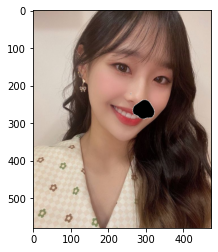

In [9]:
import math


dy = landmarks[29][1] - landmarks[27][1]
dx = landmarks[29][0] - landmarks[27][0]

angle = math.atan(dy/dx)
angle = angle * 180/ math.pi
rot_angle = 90 - angle

img_show = img_bgr.copy()

#crop nose with angle
original_width = 512
nose_left = 188
nose_width = 136
nose_top = 176
nose_height = 128

landmarks = list_landmarks[0]

nose_x = landmarks[31][0]
nose_y = landmarks[29][1]
nose_length = 2 * (landmarks[35][0]-nose_x)


sticker_nose = img_sticker[nose_top:nose_top+nose_height, nose_left:nose_left+nose_width]
sticker_nose = cv2.resize(sticker_nose, (nose_length, nose_length))

rows, cols = sticker_nose.shape[:2]
# 이미지의 중심점을 기준으로 (angle)도 회전
M= cv2.getRotationMatrix2D((cols//2, rows//2),rot_angle, 1)
dst = cv2.warpAffine(sticker_nose, M,(cols, rows),  borderValue=(255,255,255))

sticker_area = img_show[nose_y: nose_y+nose_length, nose_x:nose_x+nose_length]  # img_show 자르기
img_show[nose_y: nose_y+nose_length, nose_x:nose_x+nose_length] = np.where(dst==255,
             sticker_area,dst).astype(np.uint8)  # 스티커 자르기

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

회전이 잘 된 모습을 볼 수 있다. 그러나 위치가 잘 맞지 않는다. 또한, 머리를 오른쪽으로 기울인 사진에서는 회전이 원하는대로 되지 않는 것을 발견하여, 수정하였다.

[ 0.20486315 -0.97879063]


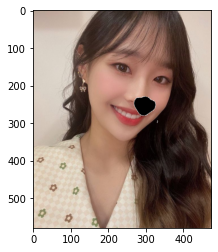

In [10]:
import numpy as np

dy = landmarks[29][1] - landmarks[27][1]
dx = landmarks[29][0] - landmarks[27][0]

angle = math.atan(dy/dx)
angle = angle * 180/ math.pi

if angle > 0:
    rot_angle = 90 - angle
else:
    rot_angle = -90 - angle 

img_show = img_bgr.copy()

#crop nose with angle, remap
original_width = 512
nose_left = 188
nose_width = 136
nose_top = 176
nose_height = 128

landmarks = list_landmarks[0]

temp_nose_vector = [landmarks[29][0] - landmarks[31][0], landmarks[29][1] - landmarks[31][1]]
noseline_vector = [landmarks[27][0] - landmarks[29][0], landmarks[27][1] - landmarks[29][1]]
normalized_noseline_vector = noseline_vector / np.linalg.norm(noseline_vector)
print(normalized_noseline_vector)
nose_scaler = np.dot(temp_nose_vector, normalized_noseline_vector)


nose_x_y = [landmarks[31][0] + nose_scaler * (normalized_noseline_vector[0] + 0.75 * normalized_noseline_vector[1])
,landmarks[31][1] + nose_scaler * (normalized_noseline_vector[1] - 0.75 * normalized_noseline_vector[0])]  
nose_x_y = [int(i) for i in nose_x_y]

nose_length = 2 * (landmarks[35][0]-landmarks[31][0])


sticker_nose = img_sticker[nose_top:nose_top+nose_height, nose_left:nose_left+nose_width]
sticker_nose = cv2.resize(sticker_nose, (nose_length, nose_length))

rows, cols = sticker_nose.shape[:2]
# 이미지의 중심점을 기준으로 (angle)도 회전
M= cv2.getRotationMatrix2D((cols//2, rows//2),rot_angle, 1)
dst = cv2.warpAffine(sticker_nose, M,(cols, rows),  borderValue=(255,255,255))

sticker_area = img_show[nose_y: nose_y+nose_length, nose_x:nose_x+nose_length]  # img_show 자르기
img_show[nose_y: nose_y+nose_length, nose_x:nose_x+nose_length] = np.where(dst==255,
             sticker_area,dst).astype(np.uint8)  # 스티커 자르기

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

사진마다 잘 안 맞는 경우가 있어 기준을 변경해본다

### 기준점 변경

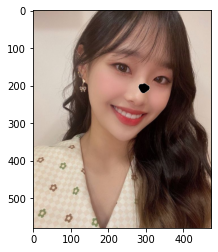

In [11]:
import numpy as np


img_show = img_bgr.copy()

dy = landmarks[29][1] - landmarks[27][1]
dx = landmarks[29][0] - landmarks[27][0]

angle = math.atan(dy/dx)
angle = angle * 180/ math.pi

if angle > 0:
    rot_angle = 90 - angle
else:
    rot_angle = -90 - angle 

#crop nose with angle, remap
original_width = 512
nose_left = 188
nose_width = 136
nose_top = 176
nose_height = 128

landmarks = list_landmarks[0]

perp_nose_vector = [landmarks[35][0] - landmarks[31][0], landmarks[35][1] - landmarks[31][1]]
normalized_perp_nose_vector = perp_nose_vector / np.linalg.norm(perp_nose_vector)


nose_x_y = [landmarks[29][0] - 0.5 *  perp_nose_vector[0] + 0.5 * perp_nose_vector[1]
,landmarks[29][1] - 0.5 * perp_nose_vector[1] - 0.5 * perp_nose_vector[0]]  
nose_x_y = [int(i) for i in nose_x_y]

nose_length = int(np.linalg.norm(perp_nose_vector))


sticker_nose = img_sticker[nose_top:nose_top+nose_height, nose_left:nose_left+nose_width]
sticker_nose = cv2.resize(sticker_nose, (nose_length, nose_length))

rows, cols = sticker_nose.shape[:2]
# 이미지의 중심점을 기준으로 (angle)도 회전
M= cv2.getRotationMatrix2D((cols//2, rows//2), rot_angle, 1)
dst = cv2.warpAffine(sticker_nose, M,(cols, rows),  borderValue=(255,255,255))

sticker_area = img_show[nose_x_y[1]: nose_x_y[1]+nose_length, nose_x_y[0]:nose_x_y[0]+nose_length]  # img_show 자르기
img_show[nose_x_y[1]: nose_x_y[1]+nose_length, nose_x_y[0]:nose_x_y[0]+nose_length] = np.where(dst==255,
             sticker_area,dst).astype(np.uint8)  # 스티커 자르기

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 정착한 알고리즘

1. 스티커를 코, 왼쪽 수염, 오른쪽 수염 3개의 정사각형으로 자른다.
2. 이미지 내 특징점을 통해 회전시키고, 크기를 맞춘다.
3. 스티커를 붙이는 위치(top, left)는 특징점을 통해 중심을 찾고, 스티커 크기의 절반씩을 빼서 찾는다.

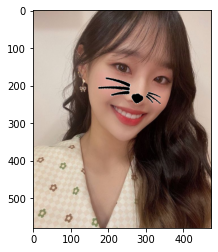

In [12]:
import numpy as np
import math


ORIGINAL_WIDTH = 512

img_show = img_bgr.copy()

landmarks = list_landmarks[0]

# - 코 좌표:
nose_left = 193
nose_width = 128
nose_top = 173
nose_height = 128

# -왼쪽 수염 좌표:
l_whisker_left = 0
l_whisker_width = 193
l_whisker_top = 166
l_whisker_height = 193

# -오른쪽 수염 좌표:
r_whisker_left = 319
r_whisker_width = 193
r_whisker_top = 166
r_whisker_height = 193

# 스티커 자르기
sticker_nose = img_sticker[nose_top:nose_top+nose_height, nose_left:nose_left+nose_width]
sticker_r_whisker = img_sticker[r_whisker_top:r_whisker_top+r_whisker_height, r_whisker_left:r_whisker_left+r_whisker_width]
sticker_l_whisker = img_sticker[l_whisker_top:l_whisker_top+l_whisker_height, l_whisker_left:l_whisker_left+l_whisker_width]


# 코 붙이기
# 각도
dy = landmarks[29][1] - landmarks[27][1]
dx = landmarks[29][0] - landmarks[27][0]
angle = math.atan(dy/dx)
angle = angle * 180 / math.pi
sign = angle / abs(angle)

if angle > 0:
 nose_angle = 90 - angle
else:
 nose_angle = -90 - angle


# 크기 & 중심점
perp_nose_vector = [landmarks[35][0] - landmarks[31][0], landmarks[35][1] - landmarks[31][1]] # 입술의 양단을 잇습니다
nose_length = int(np.linalg.norm(perp_nose_vector)) # 슬라이싱에 사용되므로 좌표의 경우 int형으로 변환해 줍니다
nose_size = (nose_length, nose_length)
offset_x, offset_y = -angle / 510 * perp_nose_vector[0], -angle / 510 * perp_nose_vector[1] # 미세조정

nose_x, nose_y = landmarks[30] # 중심점
nose_x, nose_y = int(nose_x + sign * offset_x), int(nose_y + sign * offset_y)

# 스티커 붙이기
sticker_nose = cv2.resize(sticker_nose, nose_size)
rows, cols = sticker_nose.shape[:2]
M= cv2.getRotationMatrix2D((cols//2, rows//2), nose_angle, 1)
dst = cv2.warpAffine(sticker_nose, M,(cols, rows), borderValue=(255,255,255)) # 경계는 흰색

sticker_area = img_show[nose_y - nose_length // 2 : nose_y - nose_length // 2 + cols, nose_x - nose_length // 2 :nose_x - nose_length // 2 + rows] # img_show 자르기

img_show[nose_y - nose_length // 2 : nose_y - nose_length // 2 + cols, nose_x - nose_length // 2 :nose_x - nose_length // 2 + rows] = np.where(dst==255,
 sticker_area,dst).astype(np.uint8) # 스티커 자르기


# 왼쪽 수염 붙이기
# 각도
left_whisker_vector = [landmarks[29][0] - landmarks[2][0] ,landmarks[29][1] - landmarks[2][1]]
l_angle = math.atan(left_whisker_vector[1]/left_whisker_vector[0])
l_angle = l_angle * 180 / math.pi

# 크기 & 중심점
left_whisker_length = np.linalg.norm(left_whisker_vector)
left_whisker_size = (int(left_whisker_length * 0.6), int(left_whisker_length * l_whisker_height / l_whisker_width * 0.6)) # scale factor = 0.6, 볼 밖으로 나오지 않게 하기 위해 사이즈를 줄였습니다
l_whisker_x, l_whisker_y =(landmarks[29][0] + landmarks[2][0]) // 2, (landmarks[29][1] + landmarks[2][1]) // 2 # 몫 연산 후 int가 됩니다

# 스티커 붙이기
sticker_l_whisker = cv2.resize(sticker_l_whisker, left_whisker_size)
rows, cols = sticker_l_whisker.shape[:2]
M= cv2.getRotationMatrix2D((cols//2, rows//2),abs(l_angle) * sign , 1)
dst = cv2.warpAffine(sticker_l_whisker, M,(cols, rows), borderValue=(255,255,255))

sticker_area = img_show[l_whisker_y - left_whisker_size[1] // 2: l_whisker_y - left_whisker_size[1] // 2 + cols, l_whisker_x - left_whisker_size[0] // 2: l_whisker_x - left_whisker_size[0] // 2 + rows] # img_show 자르기

img_show[l_whisker_y - left_whisker_size[1] // 2: l_whisker_y - left_whisker_size[1] // 2 + cols, l_whisker_x - left_whisker_size[0] // 2: l_whisker_x - left_whisker_size[0] // 2 + rows] = np.where(dst==255,
 sticker_area,dst).astype(np.uint8) # 스티커 자르기

# 오른쪽 수염 붙이기
# 각도
right_whisker_vector = [landmarks[29][0] - landmarks[14][0], landmarks[29][1] - landmarks[14][1]]
r_angle = math.atan(right_whisker_vector[1]/right_whisker_vector[0])
r_angle = r_angle * 180 / math.pi

# 크기 & 중심점
right_whisker_length = np.linalg.norm(right_whisker_vector)
right_whisker_size = (int(right_whisker_length * 0.6), int(right_whisker_length * r_whisker_height / r_whisker_width * 0.6)) # scale factor = 0.6, 볼 밖으로 나오지 않게 하기 위해 사이즈를 줄였습니다
r_whisker_x, r_whisker_y = (landmarks[14][0] + landmarks[29][0]) // 2, (landmarks[14][1] + landmarks[29][1]) // 2

# 스티커 붙이기
sticker_r_whisker = cv2.resize(sticker_r_whisker, right_whisker_size)
rows, cols = sticker_r_whisker.shape[:2]
M= cv2.getRotationMatrix2D((cols//2, rows//2), abs(r_angle) * sign, 1)
dst = cv2.warpAffine(sticker_r_whisker, M,(cols, rows), borderValue=(255,255,255))

sticker_area = img_show[r_whisker_y - right_whisker_size[1] // 2 : r_whisker_y - right_whisker_size[1] // 2 + cols, r_whisker_x - right_whisker_size[0] //2 :r_whisker_x - right_whisker_size[0] //2 + rows] # img_show 자르기

img_show[r_whisker_y - right_whisker_size[1] // 2 : r_whisker_y - right_whisker_size[1] // 2 + cols, r_whisker_x - right_whisker_size[0] //2 :r_whisker_x - right_whisker_size[0] //2 + rows] = np.where(dst==255,
 sticker_area,dst).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 함수로 만들기

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib


model_path = '/content/drive/MyDrive/AIffel2021/Ex03-FaceRecognition/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

sticker_path = '/content/drive/MyDrive/AIffel2021/Ex03-FaceRecognition/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)

def add_cat_whisker(my_img_path):
    img_bgr = cv2.imread(my_image_path)  # BGR 기반
    # img_bgr = cv2.resize(img_bgr, (480, 640))
    img_show = img_bgr.copy()
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    detector_hog = dlib.get_frontal_face_detector()
    dlib_rects = detector_hog(img_rgb, 2)
    
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
    

    ORIGINAL_WIDTH = 512


    # - 코 좌표:
    nose_left = 193
    nose_width = 128
    nose_top = 173
    nose_height = 128

    # -왼쪽 수염 좌표:
    l_whisker_left = 0
    l_whisker_width = 193
    l_whisker_top = 166
    l_whisker_height = 193

    # -오른쪽 수염 좌표:
    r_whisker_left = 319
    r_whisker_width = 193
    r_whisker_top = 166
    r_whisker_height = 193

    # 스티커 자르기
    sticker_nose = img_sticker[nose_top:nose_top+nose_height, nose_left:nose_left+nose_width]
    sticker_r_whisker = img_sticker[r_whisker_top:r_whisker_top+r_whisker_height, r_whisker_left:r_whisker_left+r_whisker_width]
    sticker_l_whisker = img_sticker[l_whisker_top:l_whisker_top+l_whisker_height, l_whisker_left:l_whisker_left+l_whisker_width]

    # 여러 명인 경우(bbox가 여러개)
    for i, _ in enumerate(list_landmarks):
        landmarks = list_landmarks[i] 


        # 코 붙이기
        # 각도
        dy = landmarks[29][1] - landmarks[27][1]
        dx = landmarks[29][0] - landmarks[27][0]
        try:
            angle = math.atan(dy/dx)
        except ZeroDivisionError:
            angle = (math.pi/2 - 1e-5) * dy / abs(dy)
        angle = angle * 180 / math.pi
        sign = angle / abs(angle)

        if angle > 0:
            nose_angle = 90 - angle
        else:
            nose_angle = -90 - angle


        # 크기 & 중심점
        perp_nose_vector = [landmarks[35][0] - landmarks[31][0], landmarks[35][1] - landmarks[31][1]] # 입술의 양단을 잇습니다
        nose_length = int(np.linalg.norm(perp_nose_vector)) # 슬라이싱에 사용되므로 좌표의 경우 int형으로 변환해 줍니다
        nose_size = (nose_length, nose_length)
        offset_x, offset_y = 0.1 * perp_nose_vector[0], 0.1 * perp_nose_vector[1] # 미세조정

        nose_x, nose_y = landmarks[30] # 중심점
        nose_x, nose_y = int(nose_x + sign * offset_x), int(nose_y + sign * offset_y)

        # 스티커 붙이기
        sticker_nose = cv2.resize(sticker_nose, nose_size)
        rows, cols = sticker_nose.shape[:2]
        M= cv2.getRotationMatrix2D((cols//2, rows//2), nose_angle, 1)
        dst = cv2.warpAffine(sticker_nose, M,(cols, rows), borderValue=(255,255,255)) # 경계는 흰색

        sticker_area = img_show[nose_y - nose_length // 2 : nose_y - nose_length // 2 + cols, nose_x - nose_length // 2 :nose_x - nose_length // 2 + rows] # img_show 자르기

        img_show[nose_y - nose_length // 2 : nose_y - nose_length // 2 + cols, nose_x - nose_length // 2 :nose_x - nose_length // 2 + rows] = np.where(dst==255,
        sticker_area,dst).astype(np.uint8) # 스티커 자르기


        # 왼쪽 수염 붙이기
        # 각도
        left_whisker_vector = [landmarks[29][0] - landmarks[2][0] ,landmarks[29][1] - landmarks[2][1]]
        l_angle = math.atan(left_whisker_vector[1]/left_whisker_vector[0])
        l_angle = l_angle * 180 / math.pi

        # 크기 & 중심점
        left_whisker_length = np.linalg.norm(left_whisker_vector)
        left_whisker_size = (int(left_whisker_length * 0.6), int(left_whisker_length * l_whisker_height / l_whisker_width * 0.6)) # scale factor = 0.6, 볼 밖으로 나오지 않게 하기 위해 사이즈를 줄였습니다
        l_whisker_x, l_whisker_y =(landmarks[29][0] + landmarks[2][0]) // 2, (landmarks[29][1] + landmarks[2][1]) // 2 # 몫 연산 후 int가 됩니다

        # 스티커 붙이기
        sticker_l_whisker = cv2.resize(sticker_l_whisker, left_whisker_size)
        rows, cols = sticker_l_whisker.shape[:2]
        M= cv2.getRotationMatrix2D((cols//2, rows//2),abs(l_angle) * sign , 1)
        dst = cv2.warpAffine(sticker_l_whisker, M,(cols, rows), borderValue=(255,255,255))

        sticker_area = img_show[l_whisker_y - left_whisker_size[1] // 2: l_whisker_y - left_whisker_size[1] // 2 + cols, l_whisker_x - left_whisker_size[0] // 2: l_whisker_x - left_whisker_size[0] // 2 + rows] # img_show 자르기

        img_show[l_whisker_y - left_whisker_size[1] // 2: l_whisker_y - left_whisker_size[1] // 2 + cols, l_whisker_x - left_whisker_size[0] // 2: l_whisker_x - left_whisker_size[0] // 2 + rows] = np.where(dst==255,
        sticker_area,dst).astype(np.uint8) # 스티커 자르기

        # 오른쪽 수염 붙이기
        # 각도
        right_whisker_vector = [landmarks[29][0] - landmarks[14][0], landmarks[29][1] - landmarks[14][1]]
        r_angle = math.atan(right_whisker_vector[1]/right_whisker_vector[0])
        r_angle = r_angle * 180 / math.pi

        # 크기 & 중심점
        right_whisker_length = np.linalg.norm(right_whisker_vector)
        right_whisker_size = (int(right_whisker_length * 0.6), int(right_whisker_length * r_whisker_height / r_whisker_width * 0.6)) # scale factor = 0.6, 볼 밖으로 나오지 않게 하기 위해 사이즈를 줄였습니다
        r_whisker_x, r_whisker_y = (landmarks[14][0] + landmarks[29][0]) // 2, (landmarks[14][1] + landmarks[29][1]) // 2

        # 스티커 붙이기
        sticker_r_whisker = cv2.resize(sticker_r_whisker, right_whisker_size)
        rows, cols = sticker_r_whisker.shape[:2]
        M= cv2.getRotationMatrix2D((cols//2, rows//2), abs(r_angle) * sign, 1)
        dst = cv2.warpAffine(sticker_r_whisker, M,(cols, rows), borderValue=(255,255,255))

        sticker_area = img_show[r_whisker_y - right_whisker_size[1] // 2 : r_whisker_y - right_whisker_size[1] // 2 + cols, r_whisker_x - right_whisker_size[0] //2 :r_whisker_x - right_whisker_size[0] //2 + rows] # img_show 자르기

        img_show[r_whisker_y - right_whisker_size[1] // 2 : r_whisker_y - right_whisker_size[1] // 2 + cols, r_whisker_x - right_whisker_size[0] //2 :r_whisker_x - right_whisker_size[0] //2 + rows] = np.where(dst==255,
        sticker_area,dst).astype(np.uint8)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

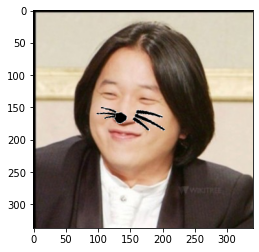

In [14]:
my_image_path = '/content/drive/MyDrive/AIffel2021/Ex03-FaceRecognition/images/image1.jpg'
add_cat_whisker(my_image_path)

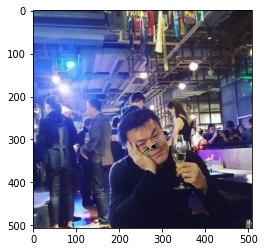

In [15]:
my_image_path = '/content/drive/MyDrive/AIffel2021/Ex03-FaceRecognition/images/jyp2.JPG'
add_cat_whisker(my_image_path)

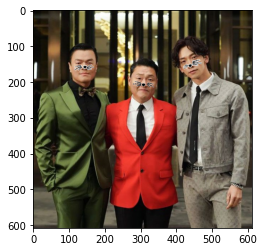

In [16]:
my_image_path = '/content/drive/MyDrive/AIffel2021/Ex03-FaceRecognition/images/jyp4.jpg'
add_cat_whisker(my_image_path)

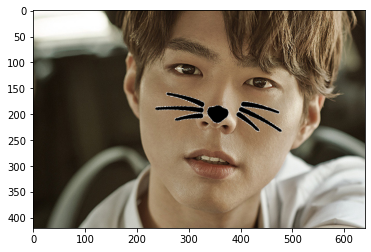

In [17]:
my_image_path = '/content/drive/MyDrive/AIffel2021/Ex03-FaceRecognition/images/bbg.jpg'
add_cat_whisker(my_image_path)

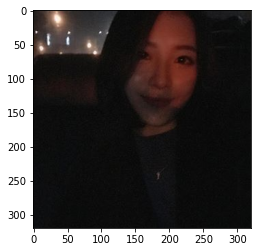

In [18]:
my_image_path = '/content/drive/MyDrive/AIffel2021/Ex03-FaceRecognition/images/dark1.jpg'
add_cat_whisker(my_image_path)

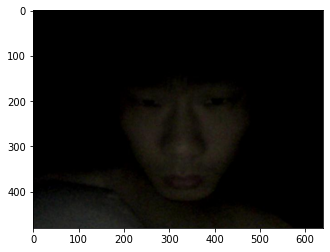

In [19]:
my_image_path = '/content/drive/MyDrive/AIffel2021/Ex03-FaceRecognition/images/dark2.jpg'
add_cat_whisker(my_image_path)

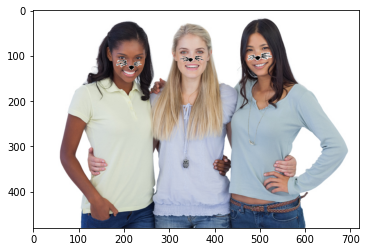

In [20]:
my_image_path = '/content/drive/MyDrive/AIffel2021/Ex03-FaceRecognition/images/3.jpg'
add_cat_whisker(my_image_path)

# 회고

1. 생각보다 위치를 맞추는게 매우 어려웠고, 과연 이게 될까 하는 마음이 늘 들었었다. 그럼에도 바로바로 결과를 얻을 수 있다는 점은 매우 좋았다.

2. 스티커 이미지를 잘라서 붙이는 생각이 잘 들어 맞은 것 같다. 손으로도 잘 분리해 낼 수 있는 경우라 다행이었다.

3. 수학에서 일반적으로 사용하는 좌표와 컴퓨터가 사용하는 좌표가 달라서, argtan 함수를 사용할 때 미궁을 헤메이는 느낌이었다.

4. 똑바로 서 있는 사람 기준, 90도 미만의 회전에 대해서는 얼굴이 인식된다면 제대로 스티커가 붙을 것 같다. 그러나 90 이상의 회전된 이미지나, 어두운 이미지에 대해서는 어떻게 하면 좋을지 잘 모르겠다. 어쩌면 HSV 색 공간에서 전처리가 필요할 수 있다.

5. 이런 식으로 이미지 조작해보는 것은 처음인데, 생각보다 재미있다